## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-14 13:03:18.082 | INFO     |  Running on cuda:0


In [3]:
task = 'SweepToDustpan'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-14 13:03:18.992 | INFO     |  Loading dataset(s): 
2024-08-14 13:03:18.992 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/SweepToDustpan/demos/metadata.json
2024-08-14 13:03:19.000 | INFO     |    Extracted gt object labels [81, 82, 83, 88, 89, 91, 93, 95]
2024-08-14 13:03:19.000 | INFO     |    Extracted tsdf object labels []
2024-08-14 13:03:19.000 | INFO     |    Done! Data contains 10 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-08-14 13:03:27.598 | INFO     |  Subsampling to length 119 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=8,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-3,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-3,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = True,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-3,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=2,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-14 13:03:27.677 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:03:27.678 | INFO     |  Performing fitting actions: [INIT]
2024-08-14 13:03:27.678 | INFO     |  Segmenting trajectories


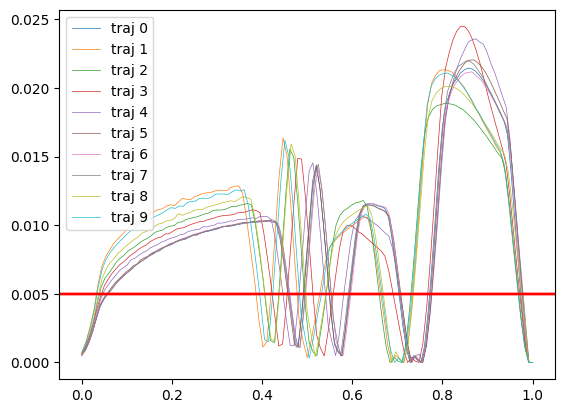

2024-08-14 13:03:27.865 | INFO     |  Creating segement of demos.
2024-08-14 13:03:27.867 | INFO     |  Subsampling to length 52 using strategy mean-length.
2024-08-14 13:03:27.868 | INFO     |  Creating segement of demos.
2024-08-14 13:03:27.870 | INFO     |  Subsampling to length 11 using strategy mean-length.
2024-08-14 13:03:27.870 | INFO     |  Creating segement of demos.
2024-08-14 13:03:27.872 | INFO     |  Subsampling to length 21 using strategy mean-length.
2024-08-14 13:03:27.873 | INFO     |  Creating segement of demos.
2024-08-14 13:03:27.875 | INFO     |  Subsampling to length 34 using strategy mean-length.
2024-08-14 13:03:27.875 | INFO     |  ... created 4 segments
2024-08-14 13:03:27.875 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:03:27.875 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:03:27.880 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-08-14 13:03:27.880 | INFO     |    Changing number of components to 3
2024-08-14 13:03:2

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:03:28.069 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:03:28.070 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:03:28.340 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-14 13:03:28.340 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-08-14 13:03:28.341 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:03:28.343 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:03:28.343 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:03:28.352 | INFO     |    Changing number of components to 2


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:28.430 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:03:28.430 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:28.497 | INFO     |  ee_init    score (rel):     -0 (0.000)
2024-08-14 13:03:28.498 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:03:28.500 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:03:28.500 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:28.629 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:03:28.630 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:28.720 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:03:28.722 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:03:28.723 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:28.896 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:03:28.897 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:03:29.019 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:03:29.021 | INFO     |  Segmented trajs into 4 segments
2024-08-14 13:03:29.031 | INFO     |  Frame score (abs):
            ee_init    obj000
Segment 0 -0.999583 -0.999270
Segment 1 -0.000412 -0.999650
Segment 2 -0.000403 -0.999615
Segment 3 -0.000395 -0.999914
2024-08-14 13:03:29.032 | INFO     |  Frame score (rel):
            ee_init    obj000
Segment 0  1.000000  0.999687
Segment 1  0.000412  1.000000
Segment 2  0.000403  1.000000
Segment 3  0.000395  1.000000


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:03:29.053 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[8.64e+012, 8.62e+012, 8.00e+012, ..., 6.94e-248, 8.95e-260,
          2.66e-269],
         [9.16e+009, 1.20e+010, 1.51e+010, ..., 1.75e+009, 1.21e+009,
          9.05e+008],
         [3.11e-240, 1.91e-238, 2.96e-236, ..., 4.81e+012, 6.78e+012,
          5.86e+012]]),
  array([[2.04e+08, 2.07e+08, 1.89e+08, 1.55e+08, 1.12e+08, 4.71e+07,
          1.66e+07, 4.80e+06, 1.30e+06, 3.67e+05, 1.16e+05, 2.07e+08,
          2.07e+08, 1.89e+08, 1.53e+08, 1.04e+08, 5.28e+07, 1.79e+07,
          4.59e+06, 1.14e+06, 3.20e+05, 0.00e+00, 2.05e+08, 2.07e+08,
          1.89e+08, 1.54e+08, 1.07e+08, 5.68e+07, 2.08e+07, 5.64e+06,
          1.39e+06, 3.67e+05, 1.14e+05, 2.06e+08, 2.08e+08, 1.89e+08,
          1.54e+08, 1.08e+08, 3.67e+07, 1.14e+07, 3.12e+06, 8.78e+05,
          2.81e+05, 0.00e+00, 2.07e+08, 2.08e+08, 1.89e+08, 1.55e+08,
          1.10e+08, 4.10e+07, 1.35e+07, 3.77e+06, 1.04e+06, 3.12e+05,
          0.00e+00, 2.06e+08, 2.08e+08, 1.89e+08, 1.55e+08, 1.11e+08,
          4.46e+07, 1.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-14 13:03:29.848 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-14 13:03:29.926 | WARNING  |  Skippig NaN Gaussians.


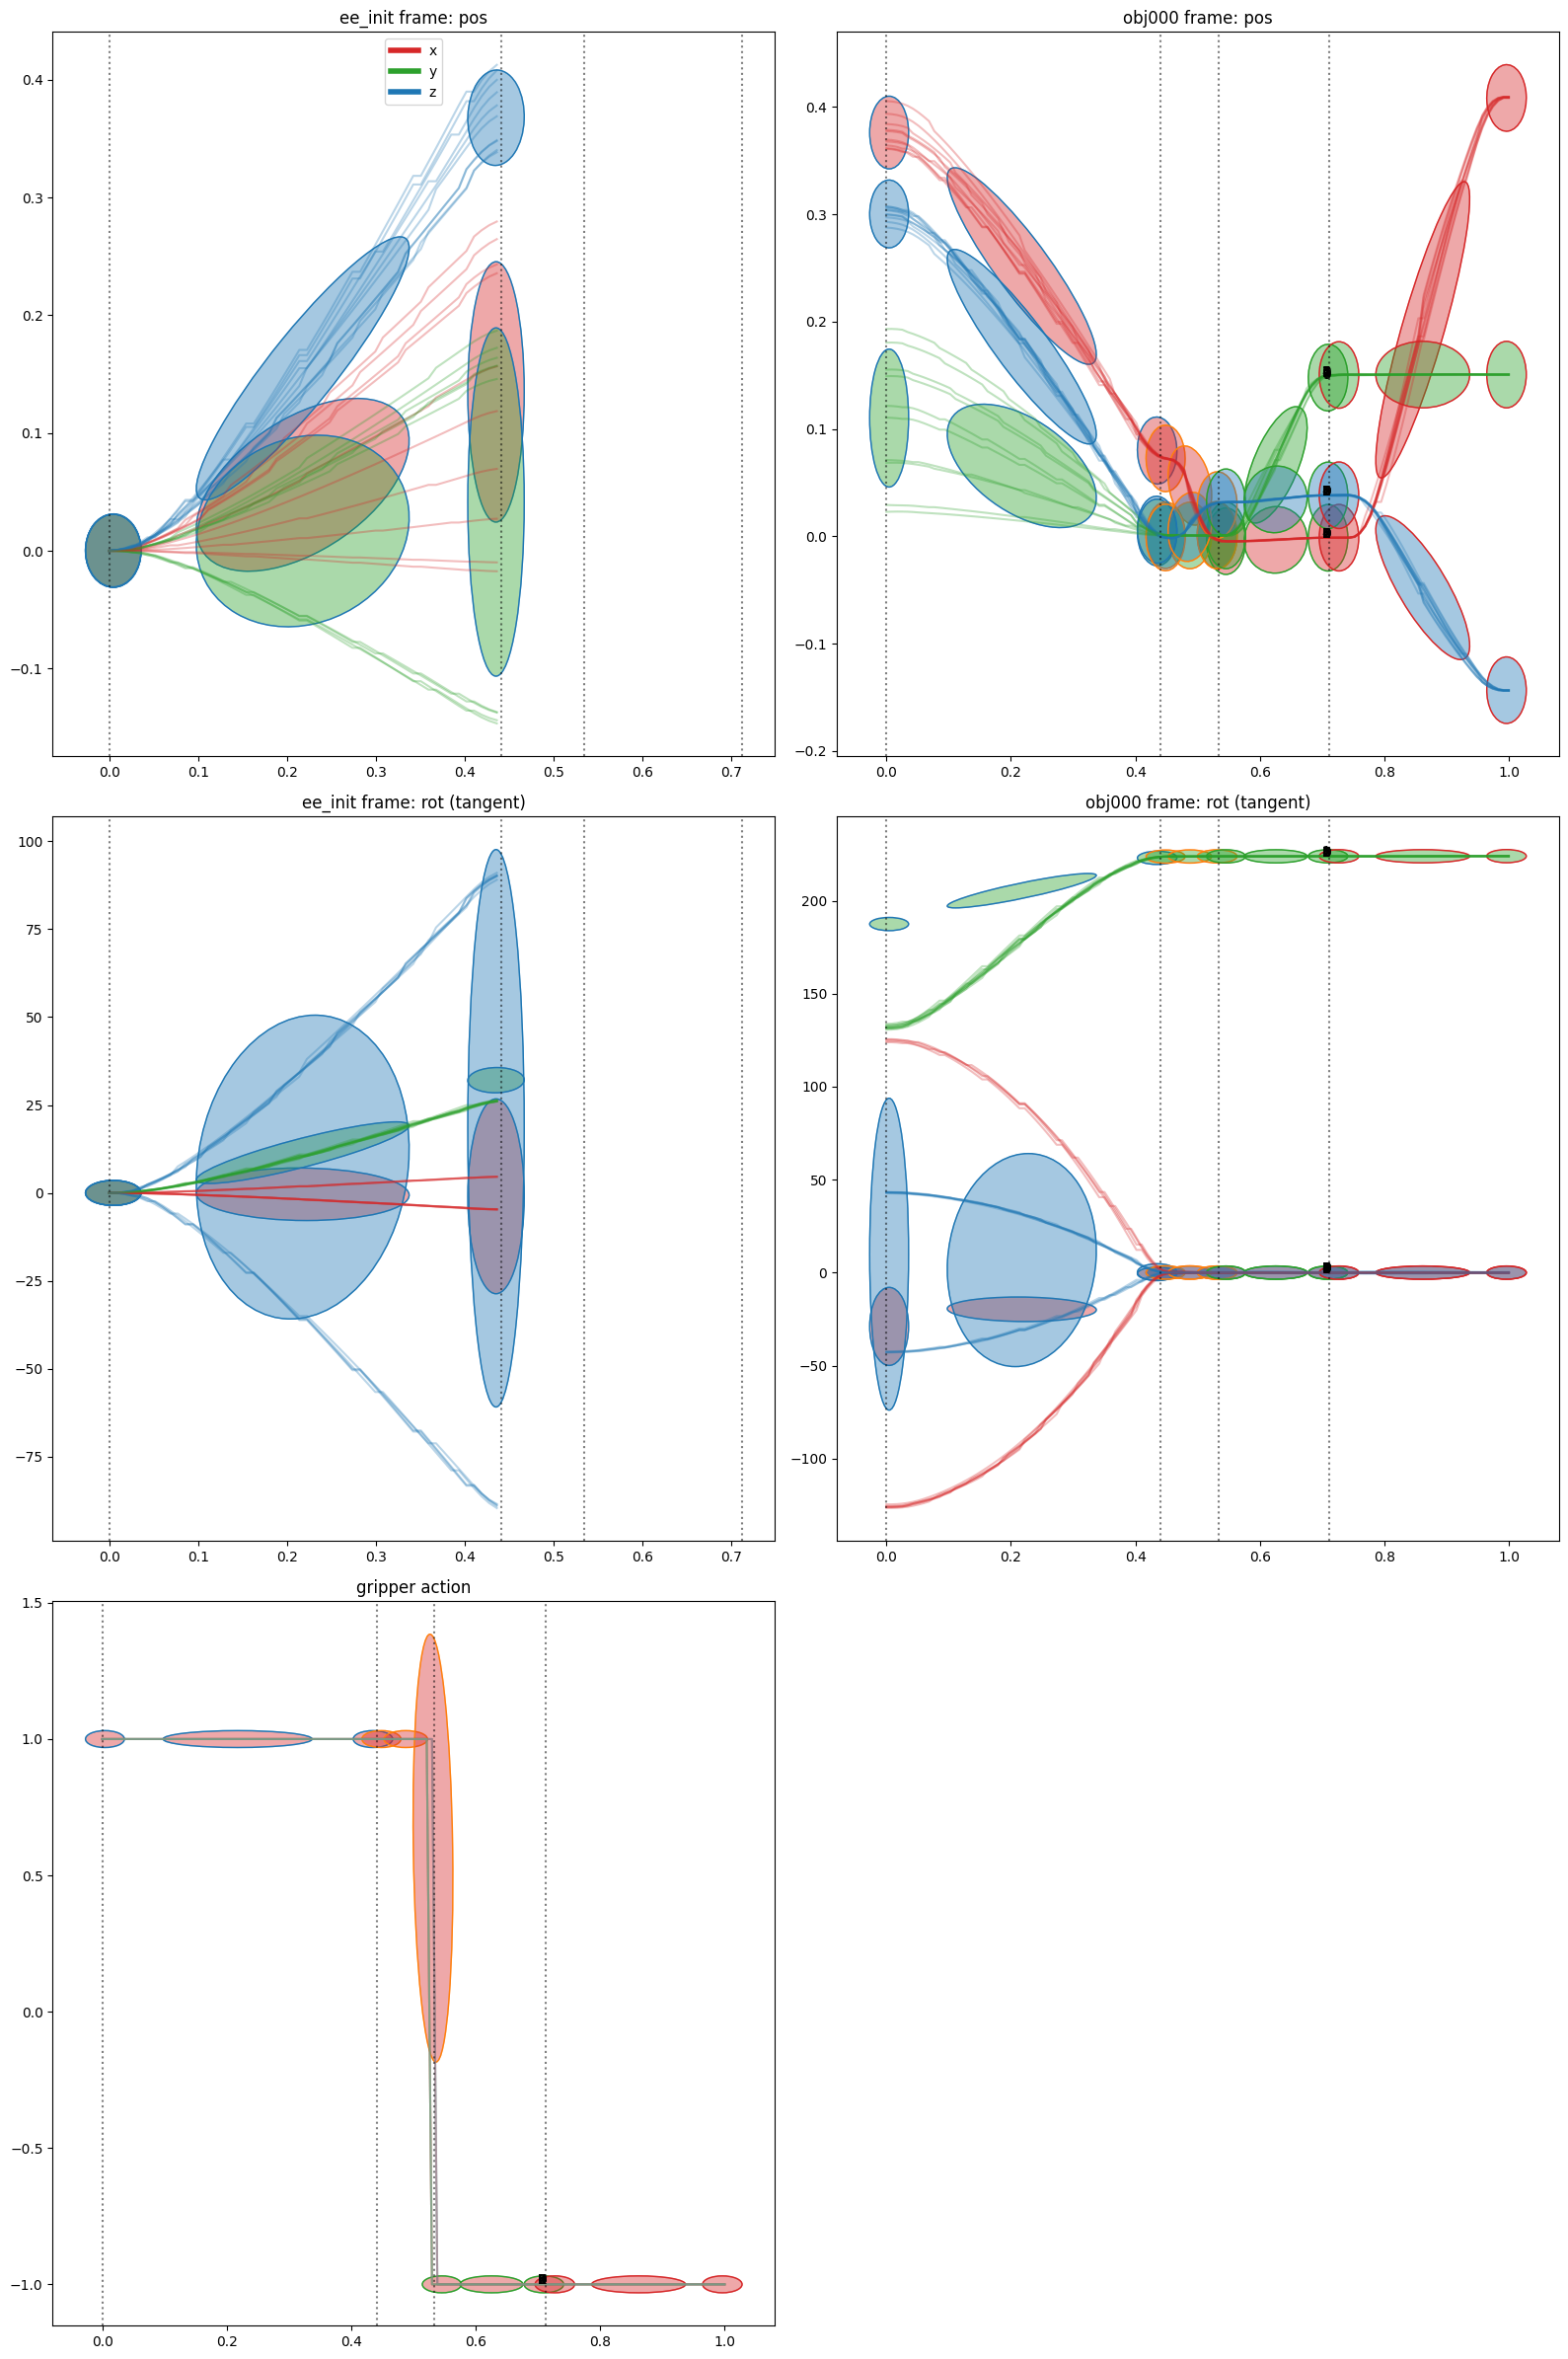

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-08-14 13:03:31.430 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:03:31.430 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:03:31.435 | INFO     |  HMM EM ...
2024-08-14 13:03:31.438 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2024-08-14 13:03:31.458 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-14 13:03:33.474 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.]]),
  array([[1.  , 1.  , 1.  , 1.  , 1.  , 0.95, 0.63, 0.16, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.96, 0.64, 0.15, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.97, 0.71, 0.2 , 0.02, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.9 , 0.46, 0.08, 0.  , 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.93, 0.53, 0.11, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.94, 0.59, 0.13, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.96, 0.64, 0.16, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.94, 0.58, 0.13, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.97, 0.68, 0.18, 0.01, 0.  , 0.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.97, 0.67, 0.17, 0.01, 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.33, 0.51, 0.19, 0.03, 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0

2024-08-14 13:03:34.995 | INFO     |  Did not specify time_based, deciding automatically.


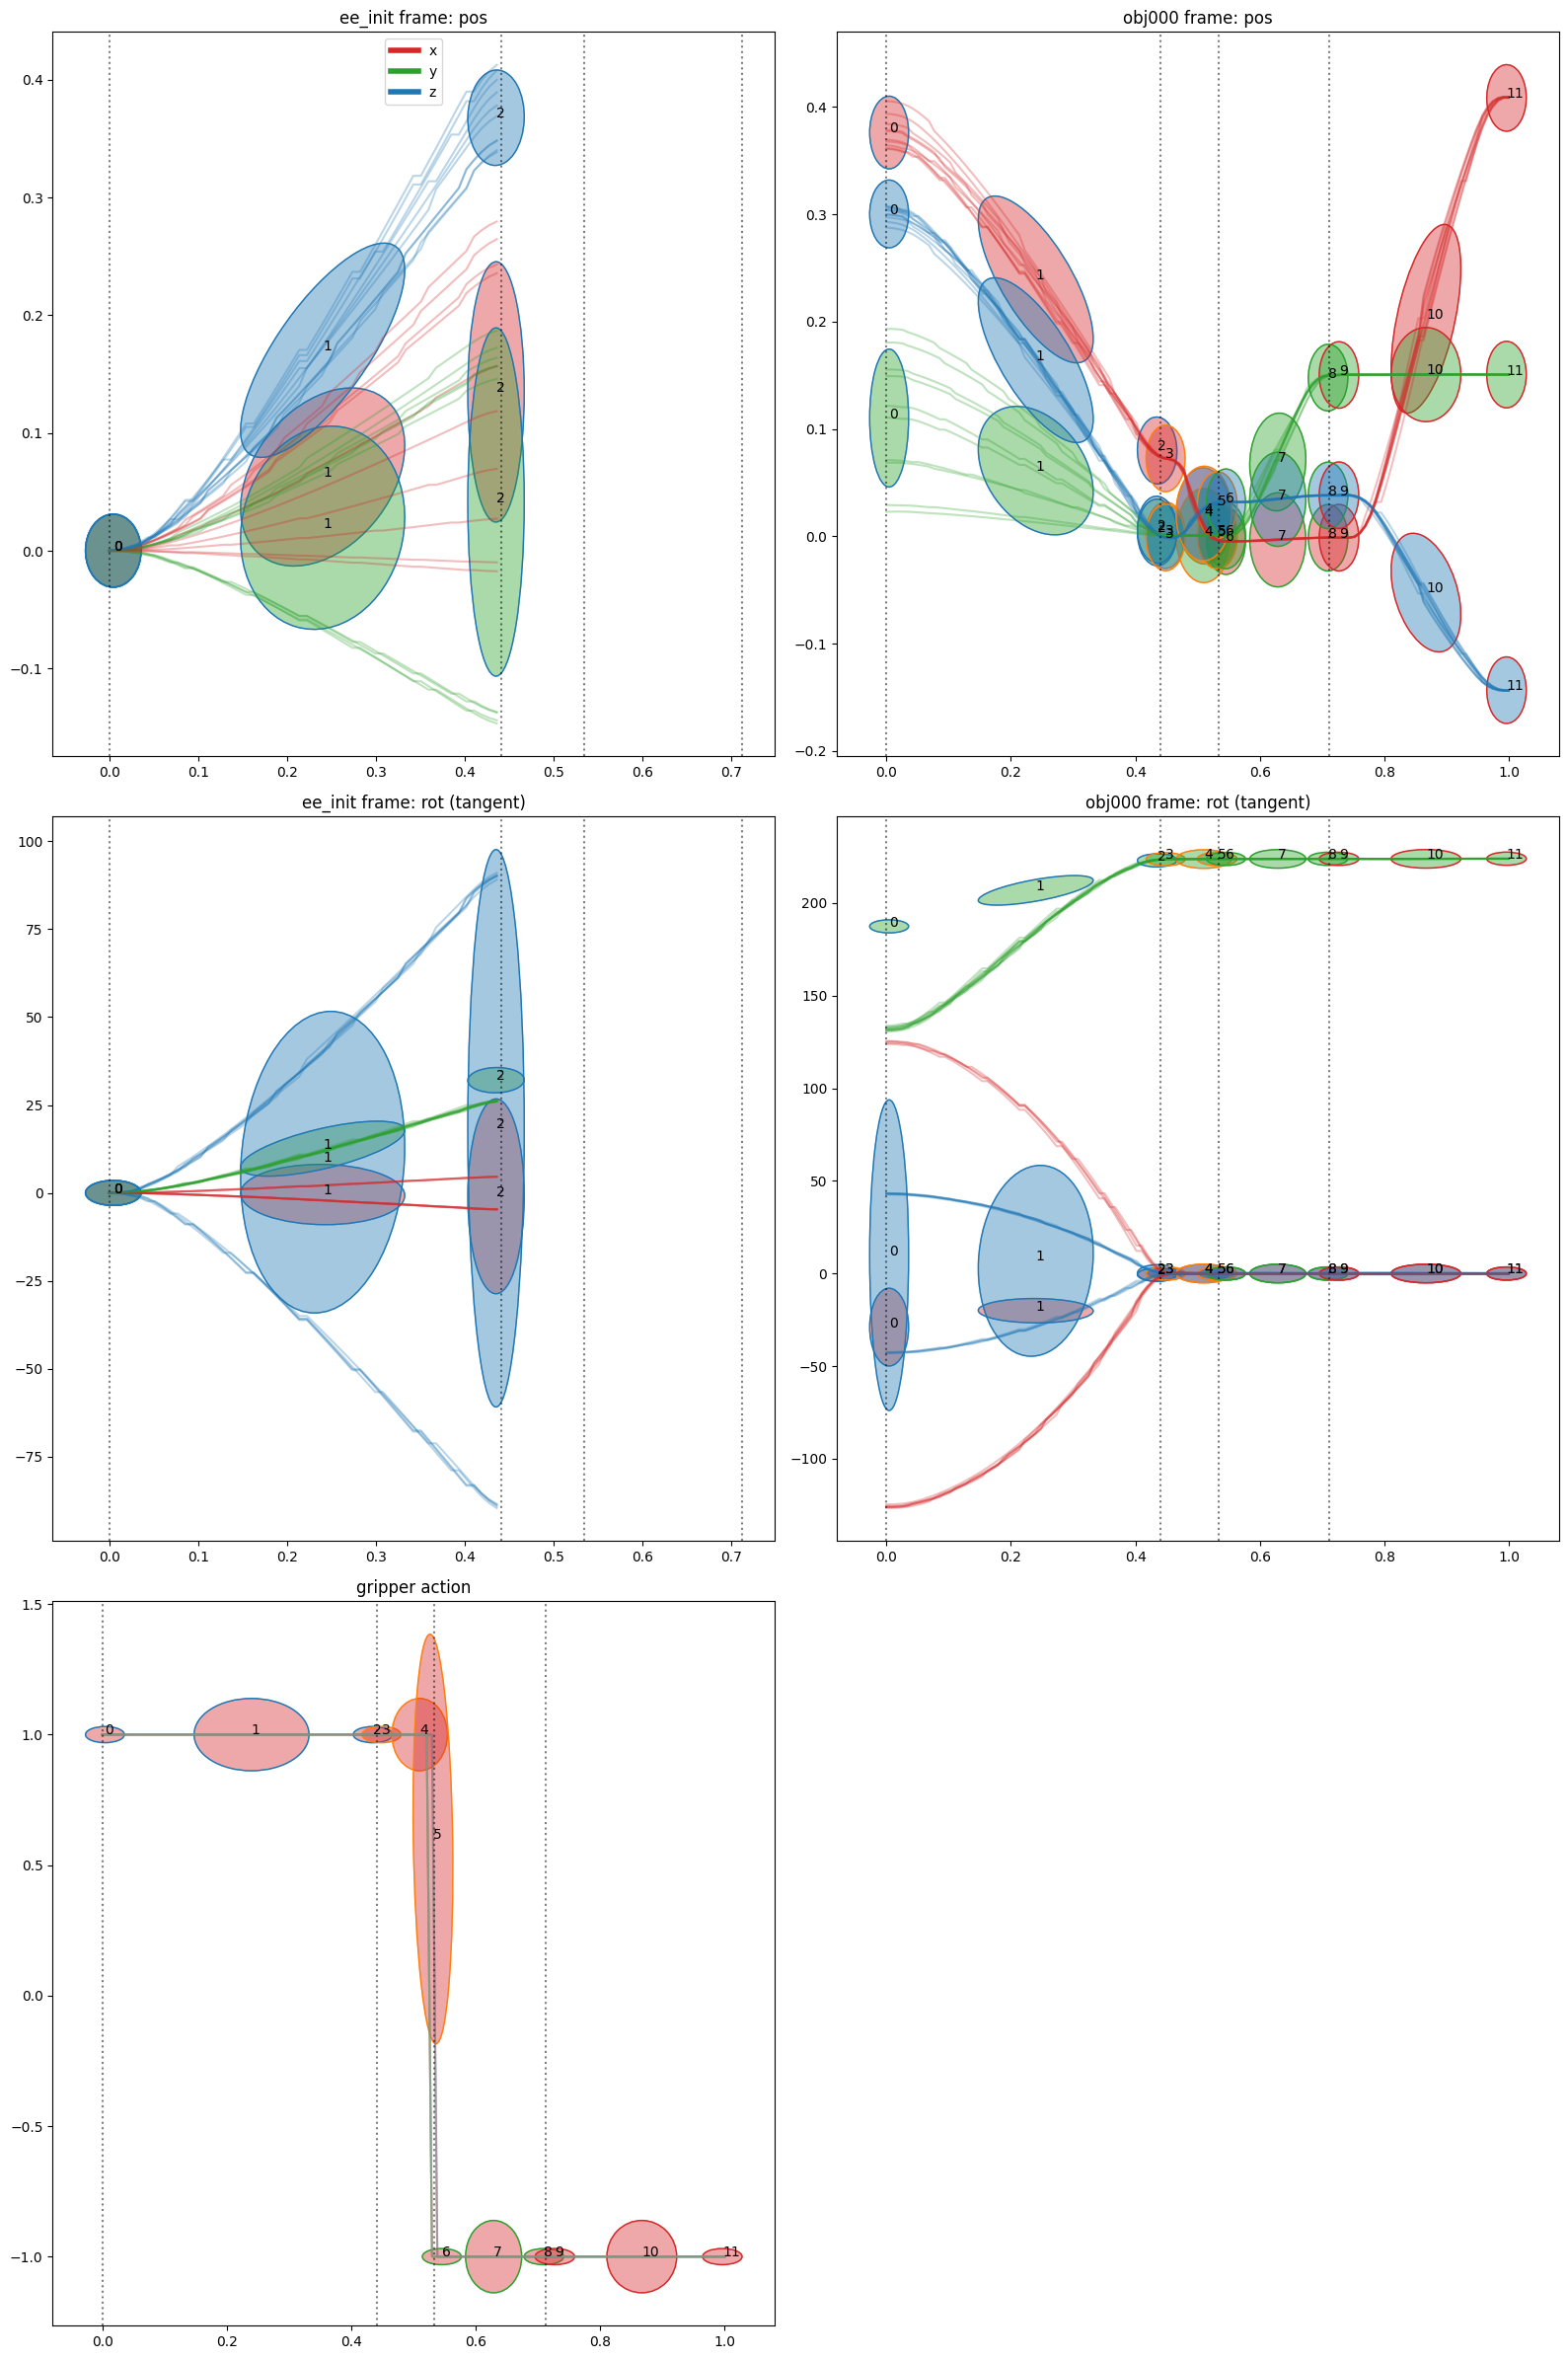

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

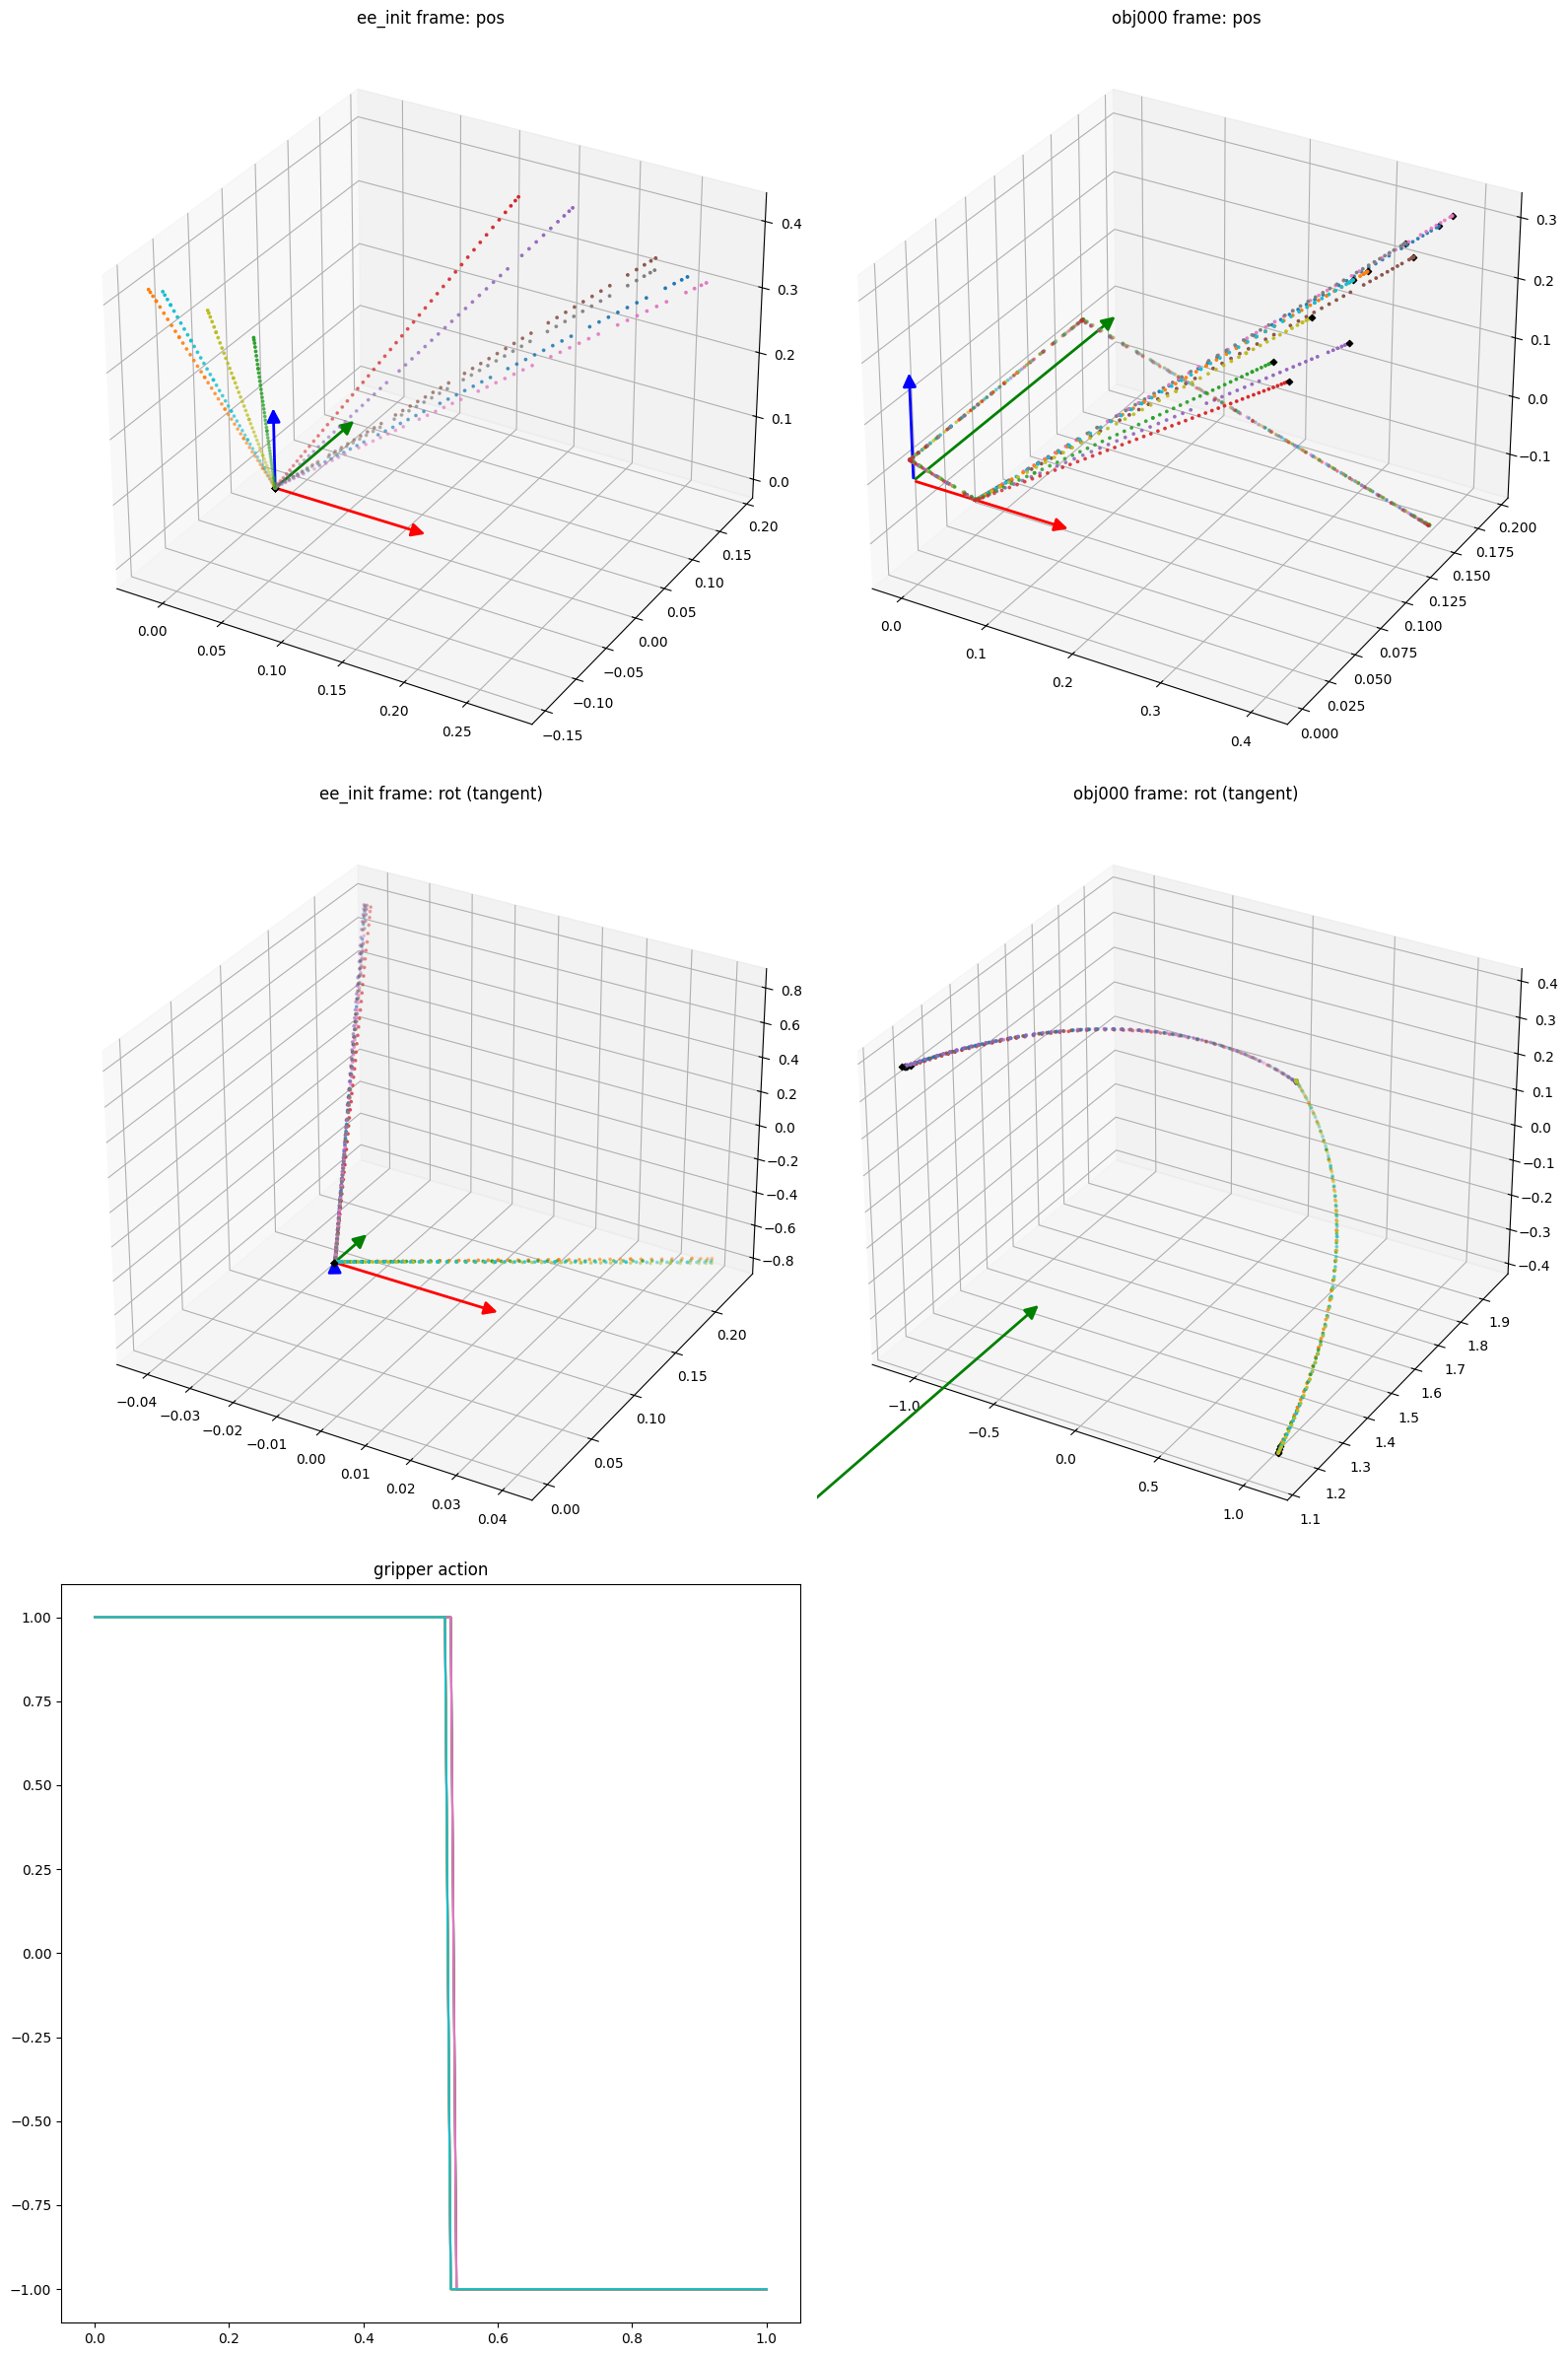

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

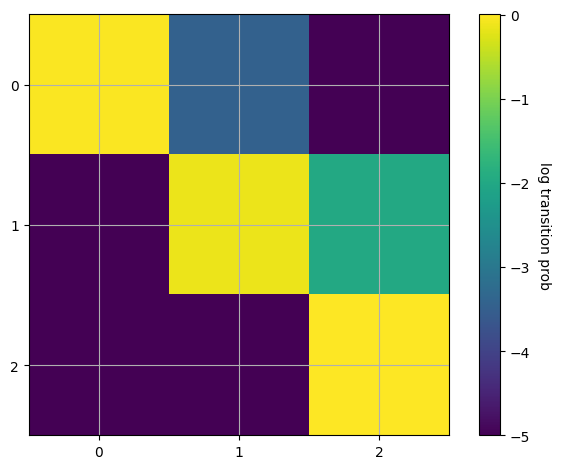

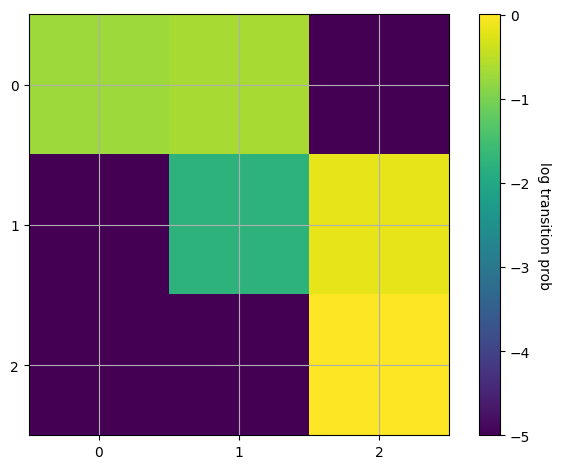

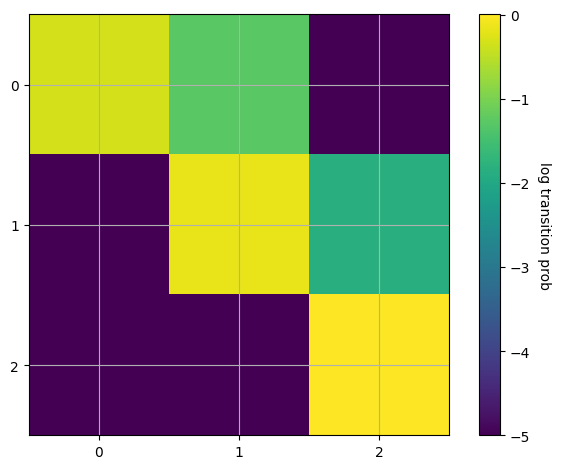

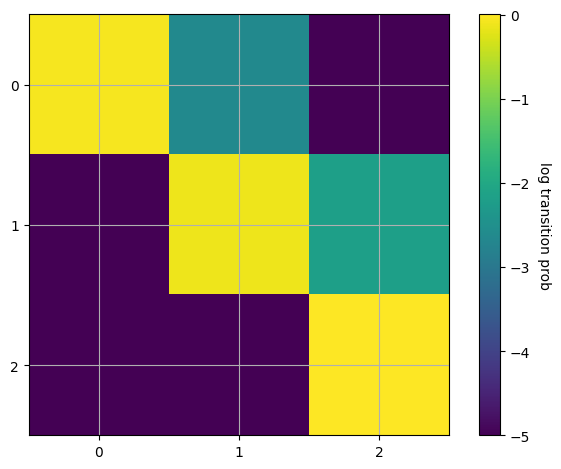

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-14 13:03:38.278 | INFO     |  Saving model:


In [16]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-14 13:03:59.842 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-14 13:03:59.886 | INFO     |  Caculated segment transition probabilities: (array([[0.95]]), array([[0.98]]), array([[1.]]))
2024-08-14 13:03:59.887 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:03:59.965 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/10 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-14 13:04:00.043 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/10 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-14 13:04:00.071 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/10 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-14 13:04:00.098 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/10 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-14 13:04:00.124 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/10 [00:00<?, ?it/s]

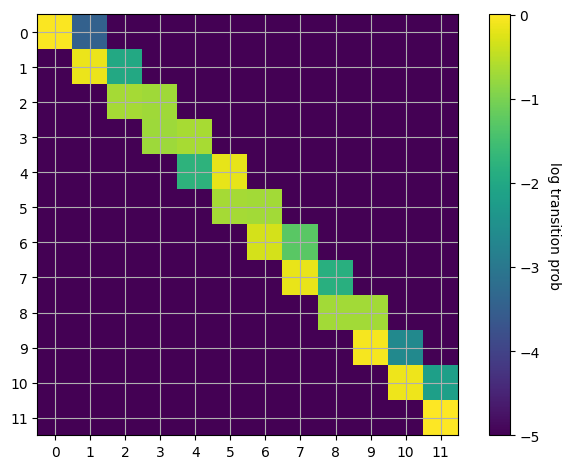

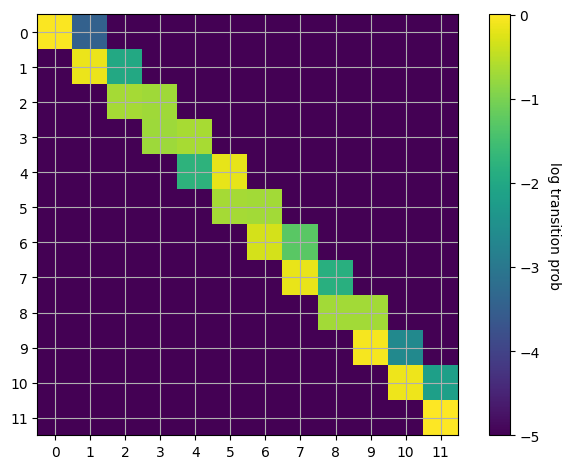

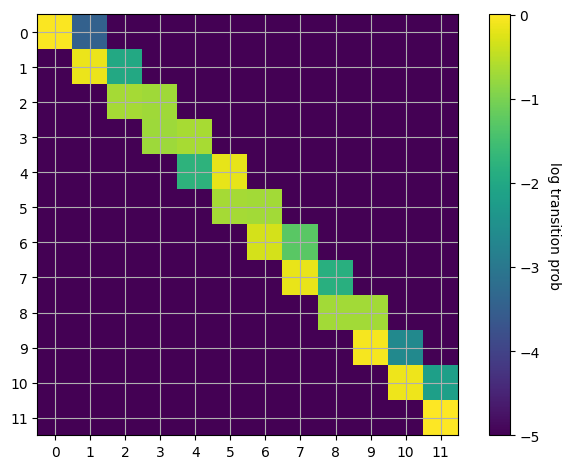

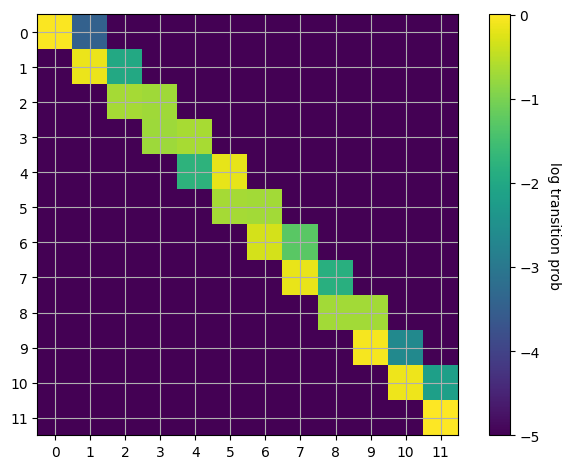

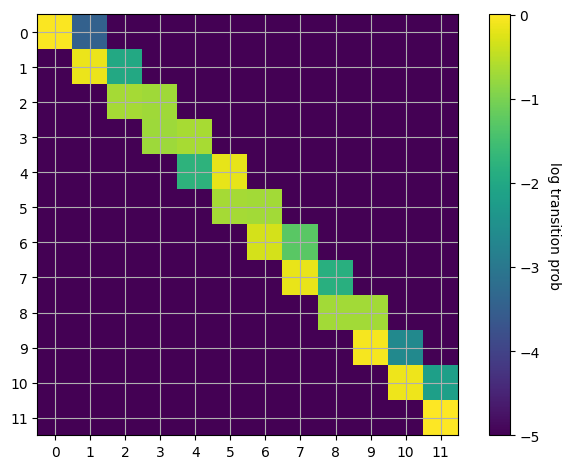

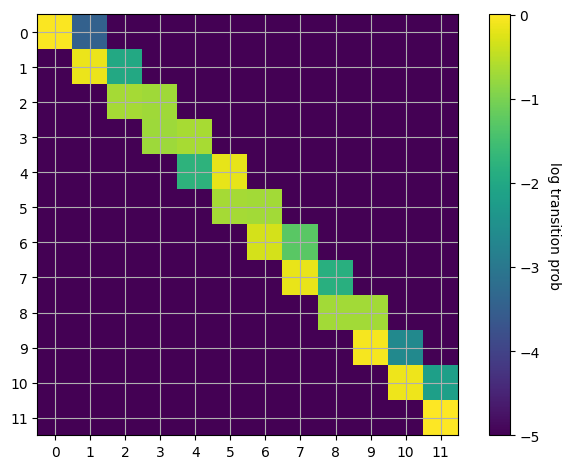

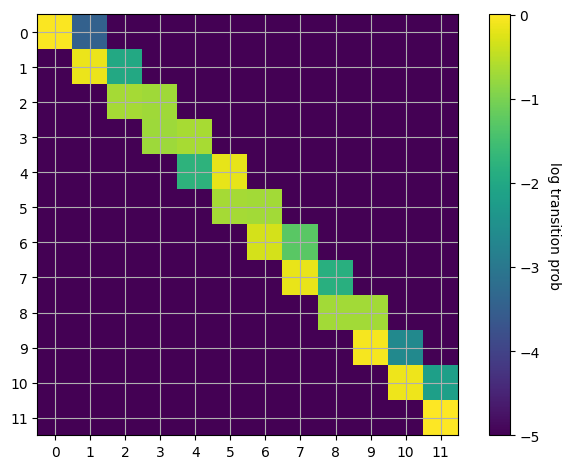

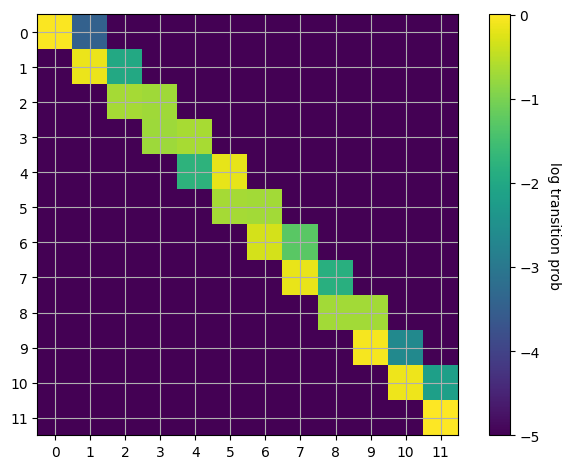

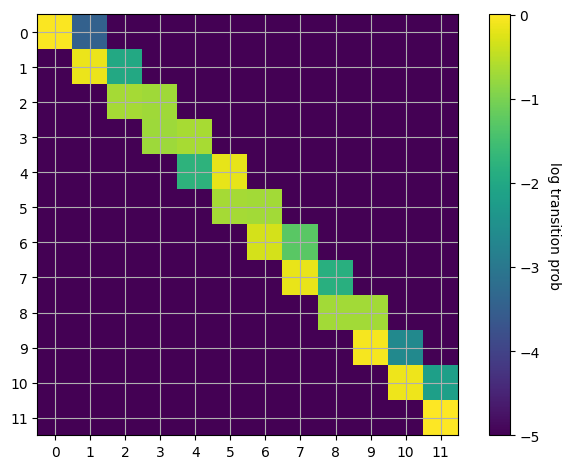

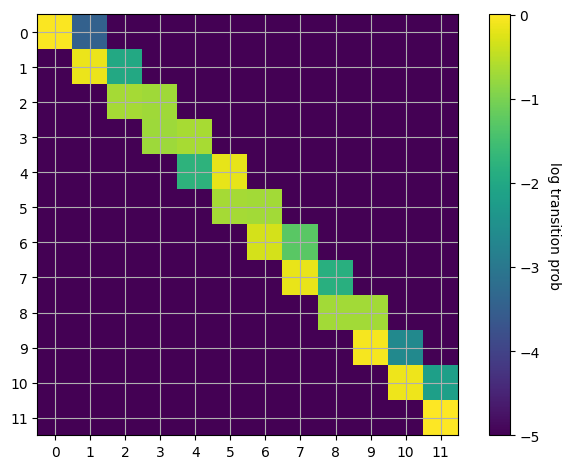

In [17]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:04:07.274 | INFO     |  Taking frame origins from demos.


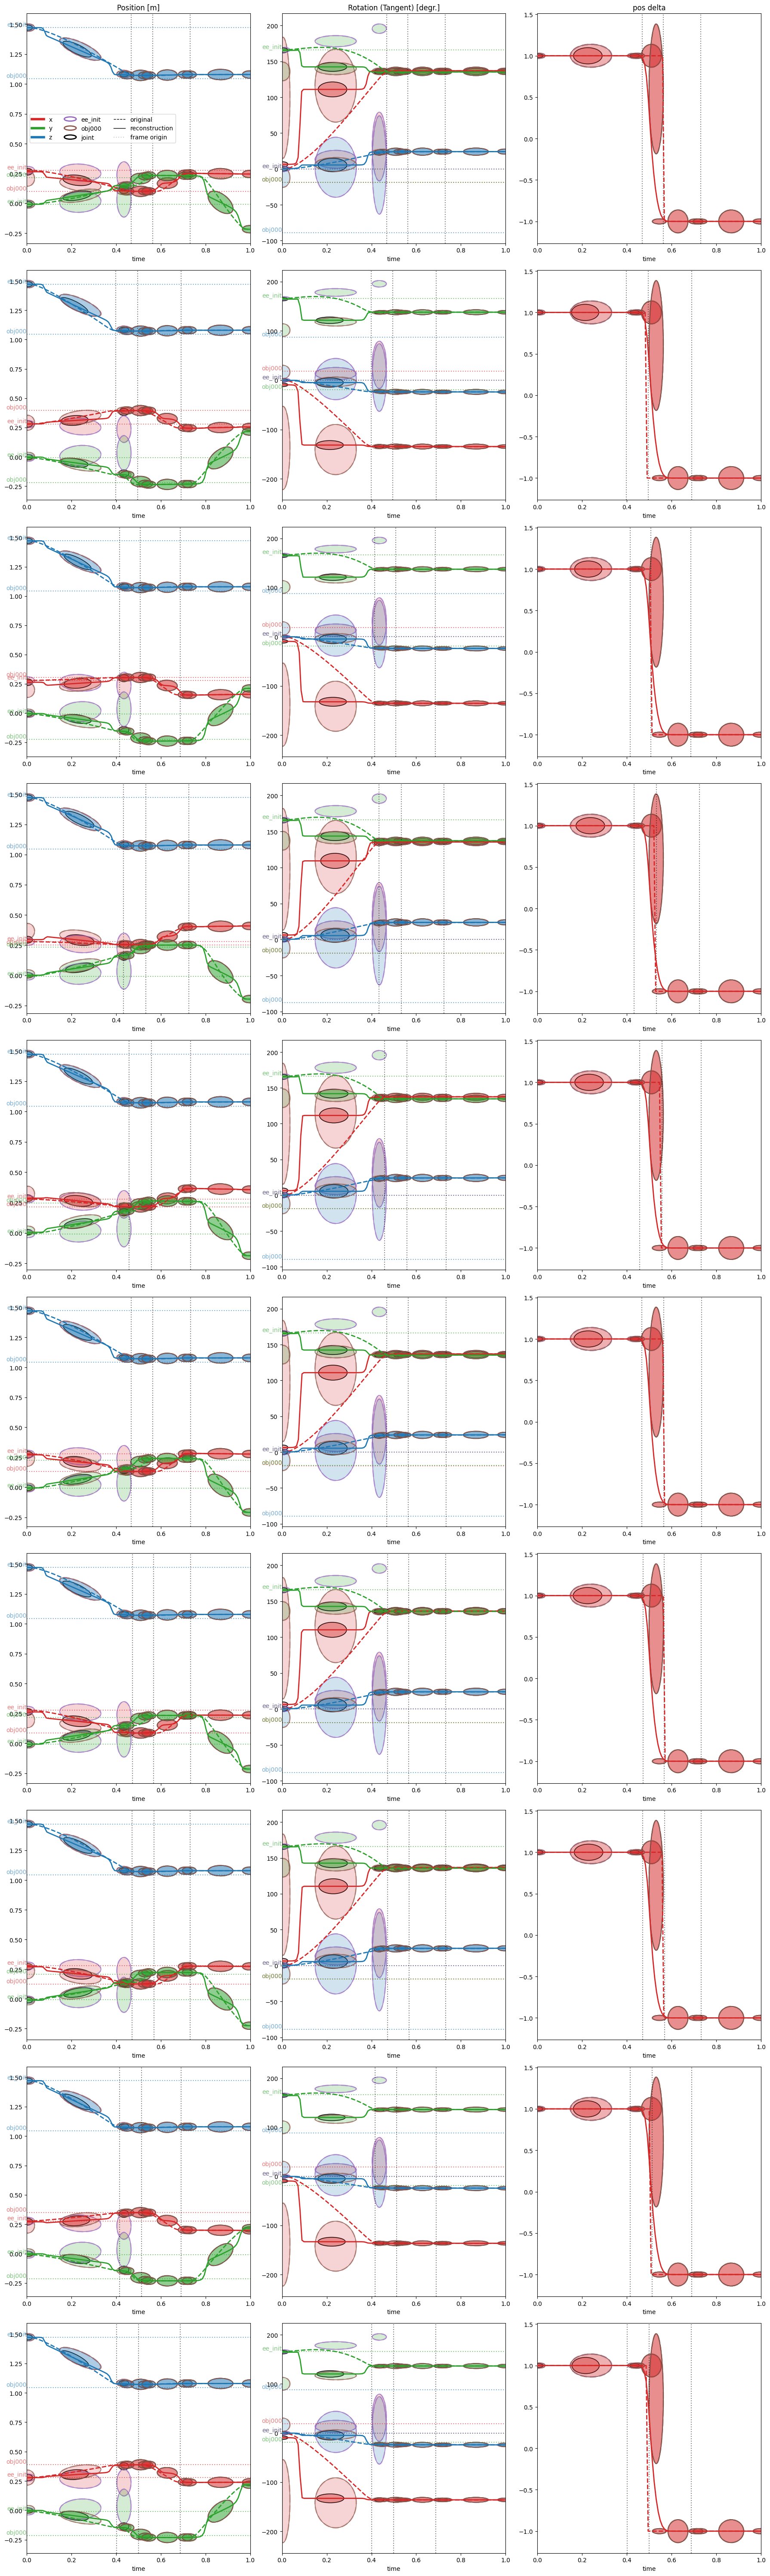

In [18]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:04:25.458 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


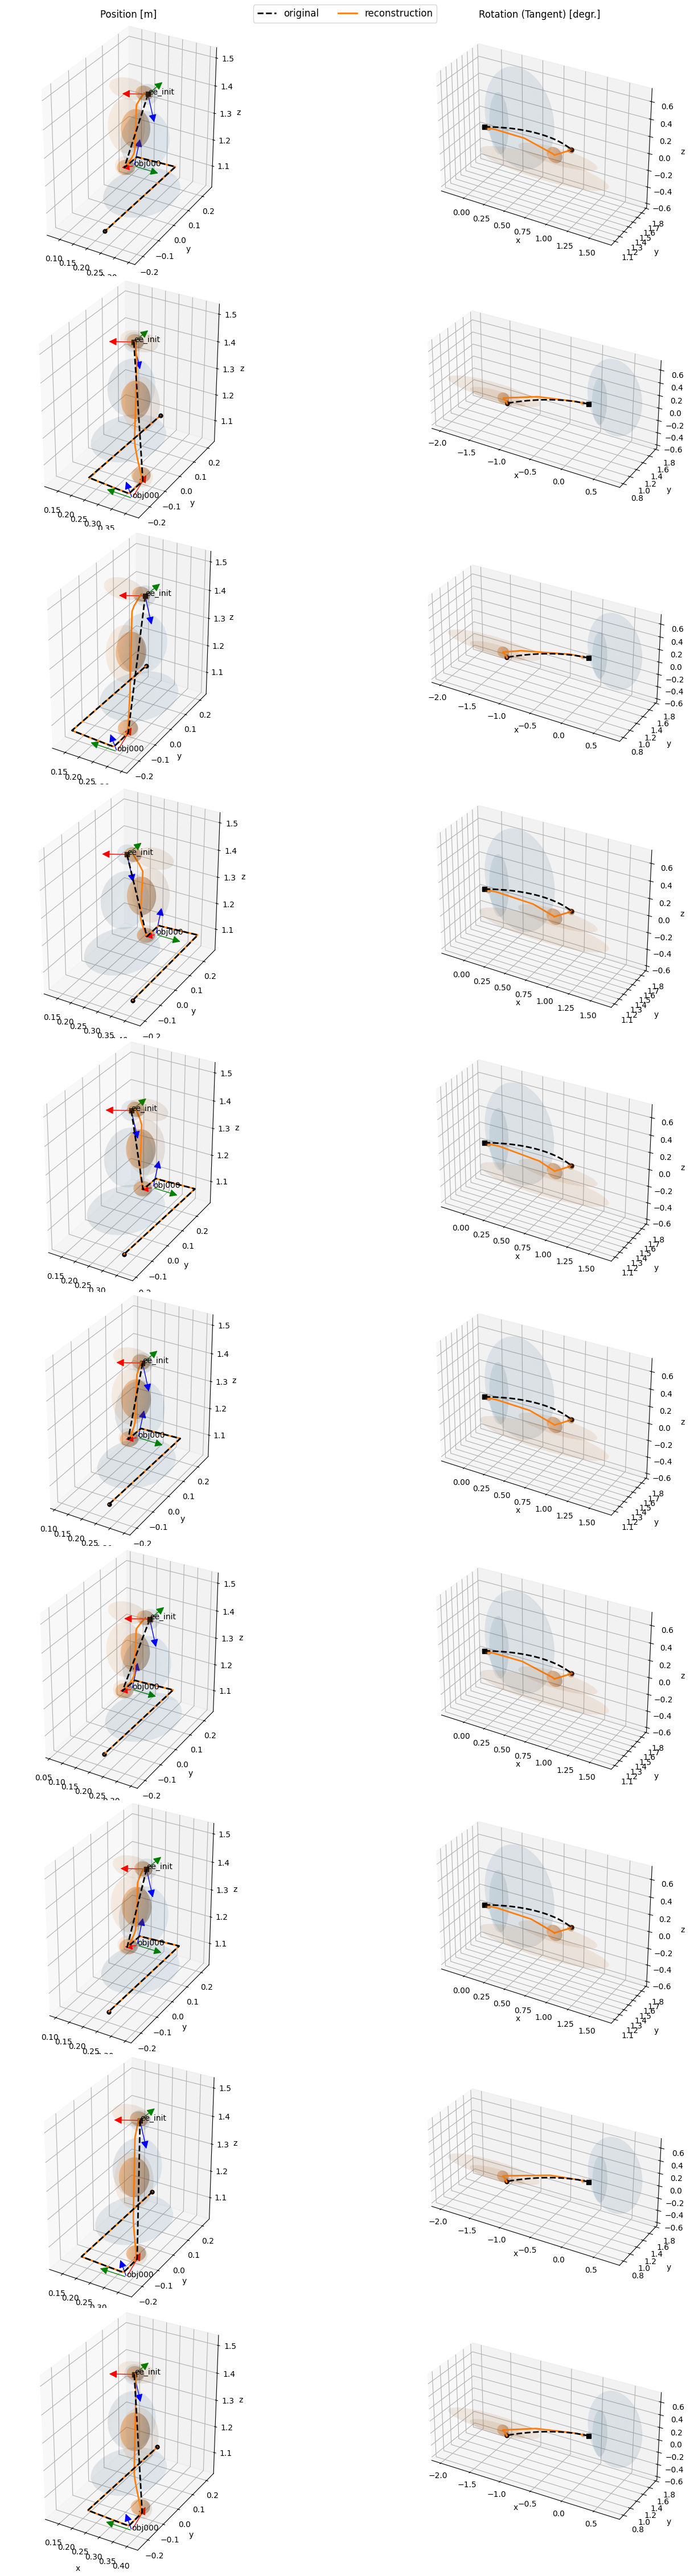

In [19]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
